I did some math by hand for the output spectrum of the cavity with no NV ensemble attached and it looks like it can reduce the number of photons in the output spectrum if the output couplings and the amplitude of the noise sources are balanced correctly. It might be better to think about it as moving the noise to a different part of the cavity set up instead of a reduction, however. I want to see if that analysis holds true for the cavity with the NV ensemble attached.


## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import integrate, signal
import sympy

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Functions

In [3]:
def photons_from_temp(ω_c, temp):
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω_c / temp) - 1) ** -1

In [4]:
def temp_from_photons(ω_c, num_photons):
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω_c / np.log(1 / num_photons + 1)

In [5]:
def get_photons_a_no_NV(ω_bounds, κ, γ, ϕ, nT, nv, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param nv:        the number of photons from the environment of the output port
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (κ * γ * nT + κ * ϕ * nv + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2  / den * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = np.abs((κ - γ - ϕ) / 2) ** 2  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [6]:
def get_photons_e_no_NV(ω_bounds, κ, γ, ϕ, nT, nv, β, Sϕ):
    """
    function for calculating the number of phonts in output e (i.e. transmission) when the NV ensemble is not connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param nT:        the number of thermal photons from the environment
    :param nv:        the number of photons from the environment of the output port
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # Noise part first
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (ϕ * κ * nT + ϕ * γ * nT + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * nv) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson( ϕ * κ  / np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2 * Sϕ, x=ω_bounds)

    noise_photons += phase_noise_photons

    # Now signal term
    signal_photons = ϕ * κ  / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [7]:
def get_photons_b_no_NV(ω_bounds, κ, γ, ϕ, nT, nv, β, Sϕ):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    noise_term = (γ * κ * nT + γ * ϕ * nv + np.abs((γ - κ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den
    noise_photons = integrate.simpson(noise_term, x=ω_bounds)

    phase_noise_photons = integrate.simpson(γ * κ / den * Sϕ, x=ω_bounds)
    noise_photons += phase_noise_photons

    signal_photons = γ * κ / np.abs((κ + γ + ϕ) / 2) ** 2 * np.abs(β) ** 2

    return noise_photons, signal_photons, noise_photons + signal_photons

In [8]:
def get_photons_a(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param nv:        the number of photons from the environment of the output port
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we have to separate out the β term
    β_term = np.abs(((κ - γ - ϕ) / 2) * (r / 2) - g ** 2) ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2
    
    # Now set up the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nT + κ * ϕ * nv) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson(np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [9]:
def get_photons_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv, β, Sϕ):
    """
    function for calculating the number of phonts in output a (i.e. reflection) when the NV ensemble is connected
    :param ω_bounds:  the frequency bounds to use for integration
    :param κ:         the output coupling rate on port a
    :param γ:         the internal loss rate of the cavity
    :param ϕ:         the output coupling rate on port e
    :param g:         the collective coupling strength between the cavity and the ensemble
    :param r:         the inhomogenous broadening of the spins
    :param nT:        the number of thermal photons from the environment
    :param nc:        the effective number of photons from the cold spin ensemble
    :param nv:        the number of photons from the environment of the output port
    :param β:         the square root of the amplitude of the coherent input
    :param Sϕ:        the phase noise power spectral density
    :return:          the number of noise photons, signal photons, and total photons
    """
    # To do the integration, we need to separate out the β term
    β_term = (r ** 2 / 4) * ϕ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    # Now do the rest
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nv
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds) 
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * ϕ * κ / den * Sϕ, x=ω_bounds)
    
    return noise_term, β_term, noise_term + β_term

In [10]:
def get_photons_b(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv, β, Sϕ):
    β_term = (r ** 2 / 4) * γ * κ / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    num = (r ** 2 / 4 + ω_bounds ** 2) * (γ * κ * nT + γ * ϕ * nv) + γ * r * g ** 2 * nc
    num += np.abs(((γ - κ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds)
    noise_term += integrate.simpson((r ** 2 / 4 + ω_bounds ** 2) * γ * κ / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [11]:
def get_photons_c(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv, β, Sϕ):
    β_term = r * κ * g ** 2 / np.abs(((κ + γ + ϕ) / 2) * (r / 2) + g ** 2) ** 2 * np.abs(β) ** 2

    num = r * (κ * nT + γ * nT + ϕ * nv) * g ** 2 
    num +=np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 + 1j * ω_bounds) - g ** 2) ** 2 * nc
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2

    noise_term = integrate.simpson(num / den, x=ω_bounds)
    noise_term += integrate.simpson(r * κ * g ** 2 / den * Sϕ, x=ω_bounds)

    return noise_term, β_term, noise_term + β_term

In [12]:
def get_spectrum_a_no_NV(ω_bounds, κ, γ, ϕ, nT, nv):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    return (κ * γ * nT + κ * ϕ * nv + np.abs((κ - γ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den

In [13]:
def get_spectrum_b_no_NV(ω_bounds, κ, γ, ϕ, nT, nv):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    return (γ * κ * nT + γ * ϕ * nv + np.abs((γ - κ - ϕ) / 2 + 1j * ω_bounds) ** 2 * nT) / den

In [14]:
def get_spectrum_e_no_NV(ω_bounds, κ, γ, ϕ, nT, nv):
    den = np.abs((κ + γ + ϕ) / 2 - 1j * ω_bounds) ** 2
    return (ϕ * κ * nT + ϕ * γ * nT + np.abs((ϕ - κ - γ) / 2 + 1j * ω_bounds) ** 2 * nv) / den

In [15]:
def get_spectrum_a(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (κ * γ * nT + κ * ϕ * nv) + κ * r * g ** 2 * nc
    num += np.abs(((κ - γ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT

    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

In [16]:
def get_spectrum_e(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (ϕ * κ * nT + ϕ * γ * nT) + ϕ * r * g ** 2 * nc
    num += np.abs(((ϕ - κ - γ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nv
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

In [17]:
def get_spectrum_c(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv):
    num = r * (κ * nT + γ * nT + ϕ * nv) * g ** 2 
    num +=np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 + 1j * ω_bounds) - g ** 2) ** 2 * nc
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

In [18]:
def get_spectrum_b(ω_bounds, κ, γ, ϕ, g, r, nT, nc, nv):
    num = (r ** 2 / 4 + ω_bounds ** 2) * (γ * κ * nT + γ * ϕ * nv) + γ * r * g ** 2 * nc
    num += np.abs(((γ - κ - ϕ) / 2 + 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) - g ** 2) ** 2 * nT
    den = np.abs(((κ + γ + ϕ) / 2 - 1j * ω_bounds) * (r / 2 - 1j * ω_bounds) + g ** 2) ** 2
    return num / den

## Calculations

First we'll assume that the couplings are the same, but we'll change $n_T$ and $n_v$ (i.e. the number of thermal photons entering the input and output ports respectively).

In [19]:
# Define parameters
ωc = 2 * np.pi * 2.87e9
ω = np.linspace(-100, 100, 1000)
κ = 10
γ = 0
ϕ = κ
nTs = np.linspace(1, 35, 1000)
nvs = 36-nTs

In [20]:
# Calculate output photons
port1_photons = [get_photons_a_no_NV(ω, κ, γ, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)]
port1_photons = np.array(port1_photons)
port2_photons = [get_photons_e_no_NV(ω, κ, γ, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)]
port2_photons = np.array(port2_photons)

tot_in_photons = 2 * ω[-1] * nTs + 2 * ω[-1] * nvs
np.allclose(tot_in_photons, port1_photons + port2_photons)

True

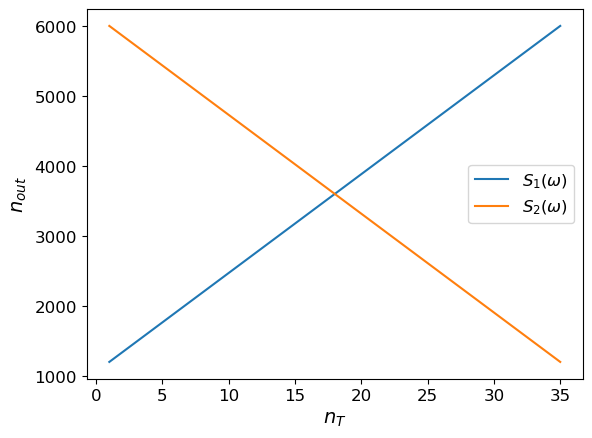

In [21]:
plt.plot(nTs, port1_photons, label='$S_1(\\omega)$')
plt.plot(nTs, port2_photons, label='$S_2(\\omega)$')
plt.xlabel("$n_T$")
plt.ylabel("$n_{out}$")
plt.legend()

How does this change when we add the internal loss rate of the cavity back in?

In [22]:
# Set internal loss rate equal to the output couplings
γ = κ

In [23]:
# Recalculate
port1_photons = [get_photons_a_no_NV(ω, κ, γ, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)]
port1_photons = np.array(port1_photons)
port2_photons = [get_photons_e_no_NV(ω, κ, γ, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)]
port2_photons = np.array(port2_photons)
loss_photons = [get_photons_b_no_NV(ω, κ, γ, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)]
loss_photons = np.array(loss_photons)

# Now the total noise photons has an extra 2γnT
tot_in_photons = 4 * ω[-1] * nTs + 2 * ω[-1] * nvs
np.allclose(tot_in_photons, port1_photons + port2_photons + loss_photons)

True

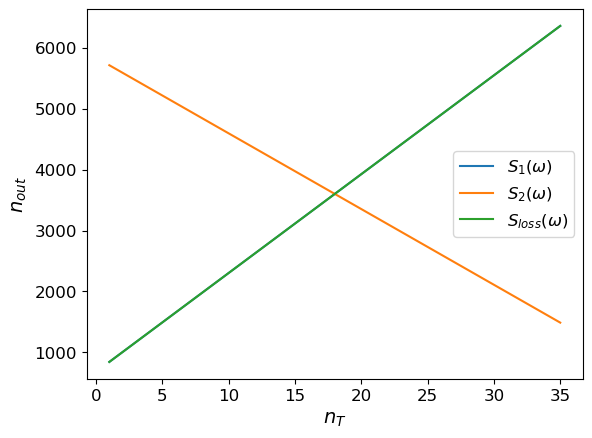

In [24]:
plt.plot(nTs, port1_photons, label='$S_1(\\omega)$')
plt.plot(nTs, port2_photons, label='$S_2(\\omega)$')
plt.plot(nTs, loss_photons, label='$S_{loss}(\\omega)$')
plt.xlabel("$n_T$")
plt.ylabel("$n_{out}$")
plt.legend()

What if $\gamma$ is not equal to $\kappa$?

In [25]:
# Set γ to be larger than κ
γ = [5, 20]

In [26]:
# Recalculate
port1_photons = [[get_photons_a_no_NV(ω, κ, y, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)] for y in γ]
port1_photons = np.array(port1_photons)
port2_photons = [[get_photons_e_no_NV(ω, κ, y, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)] for y in γ]
port2_photons = np.array(port2_photons)
loss_photons = [[get_photons_b_no_NV(ω, κ, y, ϕ, _[0], _[1], 0, 0)[0] for _ in zip(nTs, nvs)] for y in γ]
loss_photons = np.array(loss_photons)

# Now the total noise photons has an extra 2γnT
tot_in_photons = 4 * ω[-1] * nTs + 2 * ω[-1] * nvs
np.allclose(tot_in_photons, port1_photons[0] + port2_photons[0] + loss_photons[0])

True

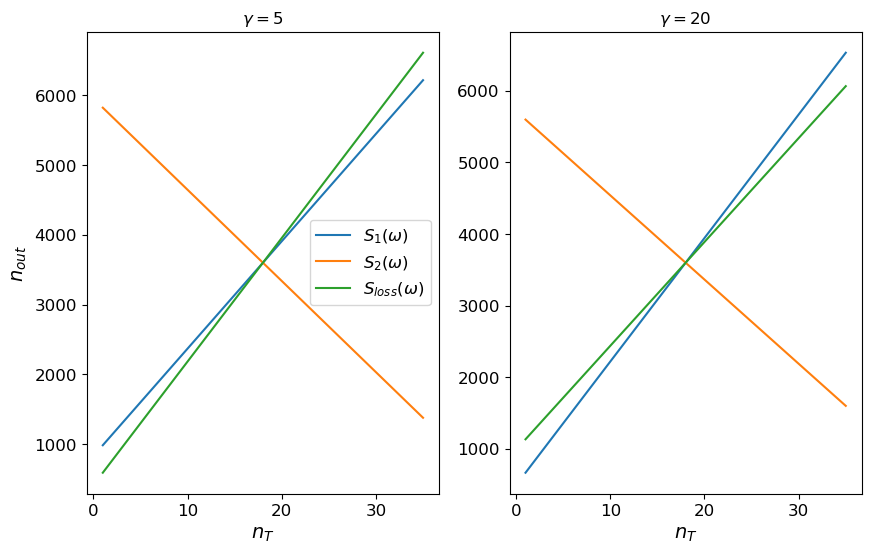

In [27]:
fig = plt.figure(1, figsize=(10,6))
ax = fig.subplots(1, 2)
ax[0].plot(nTs, port1_photons[0], label='$S_1(\\omega)$')
ax[0].plot(nTs, port2_photons[0], label='$S_2(\\omega)$')
ax[0].plot(nTs, loss_photons[0], label='$S_{loss}(\\omega)$')
ax[0].set_title("$\\gamma=5$")

ax[1].plot(nTs, port1_photons[1])
ax[1].plot(nTs, port2_photons[1])
ax[1].plot(nTs, loss_photons[1])
ax[1].set_title("$\\gamma=20$")

ax[0].set_xlabel("$n_T$")
ax[1].set_xlabel("$n_T$")
ax[0].set_ylabel("$n_{out}$")
ax[0].legend()

What if $n_T=n_v$ and $\gamma$ and $\phi$ vary while $\kappa$ remains fixed?

In [28]:
nT = 35
nv = 35
κ = np.linspace(1, 20, 1000)
ϕ = np.linspace(1, 20, 1000)
κm, ϕm = np.meshgrid(κ, ϕ)
γ = 10

In [29]:
port1_photons = [[get_photons_a_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port1_photons = np.array(port1_photons)
port2_photons = [[get_photons_e_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port2_photons = np.array(port2_photons)
loss_photons = [[get_photons_b_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
loss_photons = np.array(loss_photons)

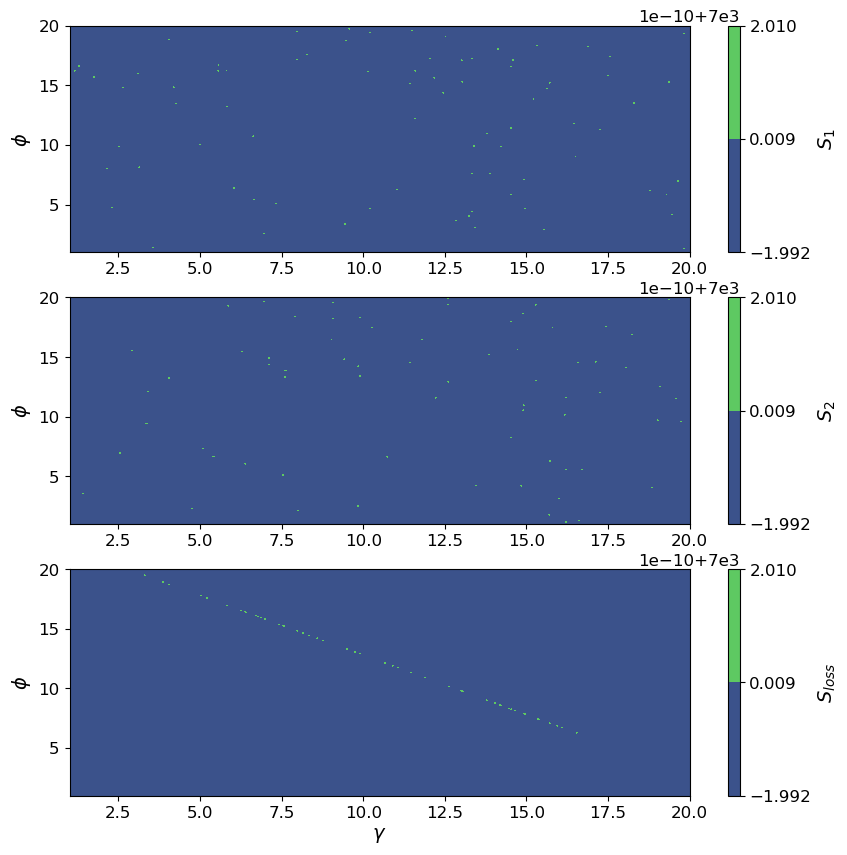

In [30]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.subplots(3, 1)
im1 = ax[0].contourf(κm, ϕm, port1_photons)
ax[0].set_ylabel("$\\phi$")
fig.colorbar(im1, label='$S_1$')

im2 = ax[1].contourf(κm, ϕm, port2_photons)
ax[1].set_ylabel('$\\phi$')
fig.colorbar(im2, label='$S_2$')

im3 = ax[2].contourf(κm, ϕm, loss_photons)
ax[2].set_ylabel("$\\phi$")
ax[2].set_xlabel("$\\gamma$")
fig.colorbar(im3, label='$S_{loss}$')

What if the output port has a lower noise term than the others?

In [31]:
nT = 35
nv = 1
κ = np.linspace(1, 20, 1000)
ϕ = np.linspace(1, 20, 1000)
κm, ϕm = np.meshgrid(κ, ϕ)
γ = 10

In [32]:
port1_photons = [[get_photons_a_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port1_photons = np.array(port1_photons)
port2_photons = [[get_photons_e_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port2_photons = np.array(port2_photons)
loss_photons = [[get_photons_b_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
loss_photons = np.array(loss_photons)

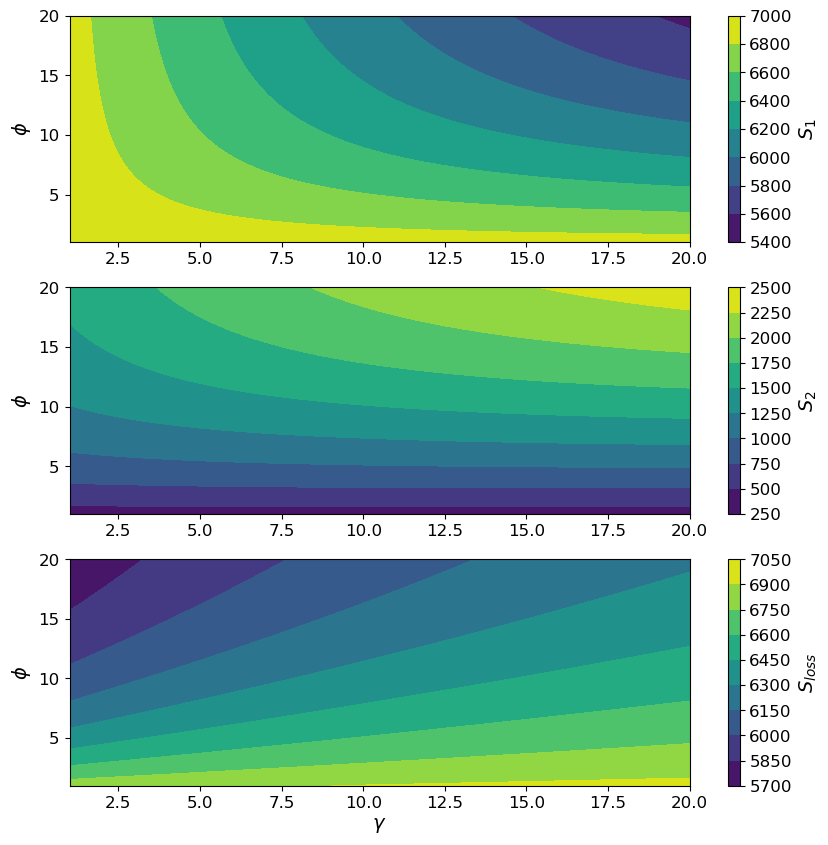

In [33]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.subplots(3, 1)
im1 = ax[0].contourf(κm, ϕm, port1_photons)
ax[0].set_ylabel("$\\phi$")
fig.colorbar(im1, label='$S_1$')

im2 = ax[1].contourf(κm, ϕm, port2_photons)
ax[1].set_ylabel('$\\phi$')
fig.colorbar(im2, label='$S_2$')

im3 = ax[2].contourf(κm, ϕm, loss_photons)
ax[2].set_ylabel("$\\phi$")
ax[2].set_xlabel("$\\gamma$")
fig.colorbar(im3, label='$S_{loss}$')

What if its the opposite?

In [34]:
nT = 1
nv = 35
κ = np.linspace(1, 20, 1000)
ϕ = np.linspace(1, 20, 1000)
κm, ϕm = np.meshgrid(κ, ϕ)
γ = 10

In [35]:
port1_photons = [[get_photons_a_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port1_photons = np.array(port1_photons)
port2_photons = [[get_photons_e_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
port2_photons = np.array(port2_photons)
loss_photons = [[get_photons_b_no_NV(ω, k, γ, p, nT, nv, 0, 0)[0] for k in κ] for p in ϕ]
loss_photons = np.array(loss_photons)

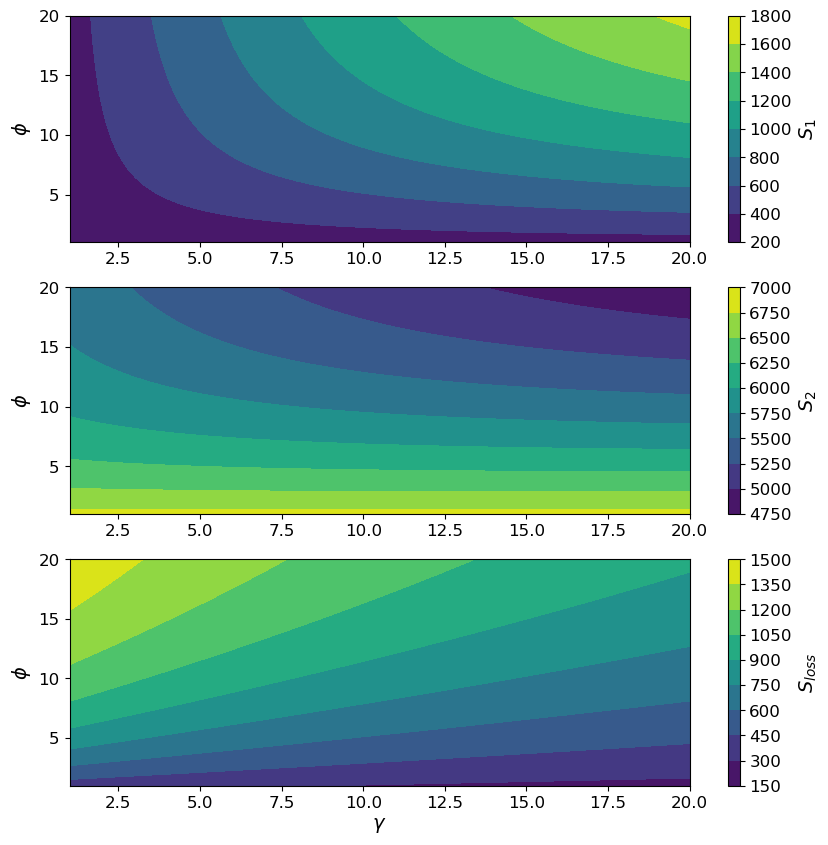

In [36]:
fig = plt.figure(1, figsize=(10,10))
ax = fig.subplots(3, 1)
im1 = ax[0].contourf(κm, ϕm, port1_photons)
ax[0].set_ylabel("$\\phi$")
fig.colorbar(im1, label='$S_1$')

im2 = ax[1].contourf(κm, ϕm, port2_photons)
ax[1].set_ylabel('$\\phi$')
fig.colorbar(im2, label='$S_2$')

im3 = ax[2].contourf(κm, ϕm, loss_photons)
ax[2].set_ylabel("$\\phi$")
ax[2].set_xlabel("$\\gamma$")
fig.colorbar(im3, label='$S_{loss}$')

## NV Ensemble
We'll start by repeating most of the parameters from the previous section.  For now, we'll assume that $g$, $r$ are basically on part with the other terms.  But we'll use $P=0.8$ so $n_c \ll n_T, n_v$.  If our previous calculations hold here, we should see most of the photons in the spectrum to the NV ensemble.  For simplicity, we'll start with $n_T=n_v$.

In [52]:
# Define parameters
ωc = 2 * np.pi * 2.87e9
ω = np.linspace(-100, 100, 1000)
κ = 10
γ = κ
ϕ = κ
nT = 35
nv = nT

# Define NV parameters
g = κ
r = 2 * g
P = 0.8
nc = 0.5 * (1 - P) / P

In [53]:
# Calculate the number of photons in each port
port1_photons = get_photons_a(ω, κ, γ, ϕ, g, r, nT, nc, nv, 0, 0)[0]
port2_photons = get_photons_e(ω, κ, γ, ϕ, g, r, nT, nc, nv, 0, 0)[0]
loss_photons = get_photons_b(ω, κ, γ, ϕ, g, r, nT, nc, nv, 0, 0)[0]
NV_photons = get_photons_c(ω, κ, γ, ϕ, g, r, nT, nc, nv, 0, 0)[0]
tot_in_photons = 4 * ω[-1] * nT + 2 * ω[-1] * nv + 2 * ω[-1] * nc

In [54]:
# Print
print("Photons in port 1: ", port1_photons)
print("Photons in port 2: ", port2_photons)
print("Photons in loss: ", loss_photons)
print("Photons in NV: ", NV_photons)
print("Total: ", tot_in_photons, port1_photons + port2_photons + loss_photons + NV_photons)

Photons in port 1:  6649.8596810778145
Photons in port 2:  6649.8596810778145
Photons in loss:  6649.8596810778145
Photons in NV:  1075.4209567665541
Total:  21025.0 21024.999999999996


Now let's look at what happens as the balance between the 2 outputs changes

In [55]:
nTs = np.linspace(1, 35, 1000)
nvs = 72 - 2*nTs

In [56]:
# Calculate the number of photons in each port
port1_photons = np.array([get_photons_a(ω, κ, γ, ϕ, g, r, _[0], nc, _[1], 0, 0)[0] for _ in zip(nTs, nvs)])
port2_photons = np.array([get_photons_e(ω, κ, γ, ϕ, g, r, _[0], nc, _[1], 0, 0)[0] for _ in zip(nTs, nvs)])
loss_photons = np.array([get_photons_b(ω, κ, γ, ϕ, g, r, _[0], nc, _[1], 0, 0)[0] for _ in zip(nTs, nvs)])
NV_photons = np.array([get_photons_c(ω, κ, γ, ϕ, g, r, _[0], nc, _[1], 0, 0)[0] for _ in zip(nTs, nvs)])
tot_in_photons = 4 * ω[-1] * nTs[1] + 2 * ω[-1] * nvs[1] + 2 * ω[-1] * nc
print(np.allclose(tot_in_photons, port1_photons[0] + port2_photons[0] + loss_photons[0] + NV_photons[0]))

True


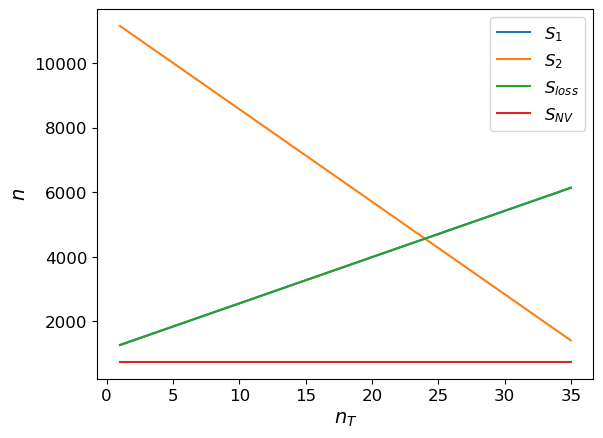

In [57]:
plt.plot(nTs, port1_photons, label='$S_1$')
plt.plot(nTs, port2_photons, label='$S_2$')
plt.plot(nTs, loss_photons, label='$S_{loss}$')
plt.plot(nTs, NV_photons, label='$S_{NV}$')
#plt.plot(nTs, port1_photons + port2_photons + loss_photons + NV_photons, label='Total')
plt.xlabel("$n_T$")
plt.ylabel("$n$")
plt.legend()

This is kind of the opposite of what I expected.  Yes, the NV ensemble has the lowest 'noise' because $n_c = 0.125$ so it's mostly where the most photons have gone, but not always.  There's a region where the second port has the most photons at low $n_T$, which is weird because that's when $n_v$ is the highest.

Let's look at the spectra themselves.

In [58]:
# Define parameters
ωc = 2 * np.pi * 2.87e9
ω = np.linspace(-100, 100, 1000)
κ = 10
γ = κ
ϕ = κ
nT = 35
nv = nT

# Define NV parameters
g = κ
r = 2 * g
P = 0.8
nc = 0.5 * (1 - P) / P

In [59]:
Sa = get_spectrum_a(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sb = get_spectrum_b(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sc = get_spectrum_c(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Se = get_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, nv)

Sa_no_NV = get_spectrum_a_no_NV(ω, κ, γ, ϕ, nT, nv)
Sb_no_NV = get_spectrum_b_no_NV(ω, κ, γ, ϕ, nT, nv)
Se_no_NV = get_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, nv)

Text(0.5, 1.0, 'NV')

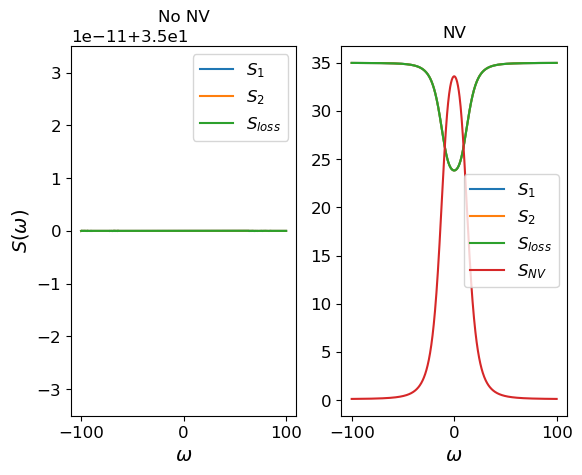

In [60]:
fig = plt.figure(1)
ax = fig.subplots(1, 2)
ax[0].plot(ω, Sa_no_NV, label='$S_1$')
ax[0].plot(ω, Se_no_NV, label='$S_2$')
ax[0].plot(ω, Sb_no_NV, label='$S_{loss}$')
ax[0].legend()
ax[0].set_xlabel("$\\omega$")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].set_title("No NV")

ax[1].plot(ω, Sa, label='$S_1$')
ax[1].plot(ω, Se, label='$S_2$')
ax[1].plot(ω, Sb, label='$S_{loss}$')
ax[1].plot(ω, Sc, label='$S_{NV}$')
ax[1].legend()
ax[1].set_xlabel("$\\omega$")
ax[1].set_title("NV")

What if $n_v < n_T$?

In [61]:
nv = 1

In [62]:
Sa = get_spectrum_a(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sb = get_spectrum_b(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sc = get_spectrum_c(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Se = get_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, nv)

Sa_no_NV = get_spectrum_a_no_NV(ω, κ, γ, ϕ, nT, nv)
Sb_no_NV = get_spectrum_b_no_NV(ω, κ, γ, ϕ, nT, nv)
Se_no_NV = get_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, nv)

Text(0.5, 1.0, 'NV')

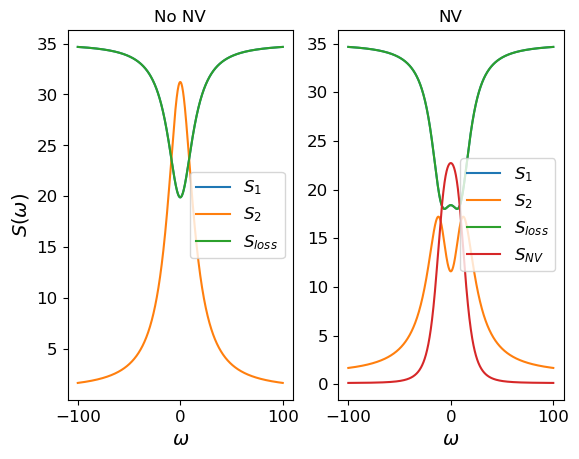

In [63]:
fig = plt.figure(1)
ax = fig.subplots(1, 2)
ax[0].plot(ω, Sa_no_NV, label='$S_1$')
ax[0].plot(ω, Se_no_NV, label='$S_2$')
ax[0].plot(ω, Sb_no_NV, label='$S_{loss}$')
ax[0].legend()
ax[0].set_xlabel("$\\omega$")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].set_title("No NV")

ax[1].plot(ω, Sa, label='$S_1$')
ax[1].plot(ω, Se, label='$S_2$')
ax[1].plot(ω, Sb, label='$S_{loss}$')
ax[1].plot(ω, Sc, label='$S_{NV}$')
ax[1].legend()
ax[1].set_xlabel("$\\omega$")
ax[1].set_title("NV")

In [64]:
nT = 1
nv = 35

In [65]:
Sa = get_spectrum_a(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sb = get_spectrum_b(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Sc = get_spectrum_c(ω, κ, γ, ϕ, g, r, nT, nc, nv)
Se = get_spectrum_e(ω, κ, γ, ϕ, g, r, nT, nc, nv)

Sa_no_NV = get_spectrum_a_no_NV(ω, κ, γ, ϕ, nT, nv)
Sb_no_NV = get_spectrum_b_no_NV(ω, κ, γ, ϕ, nT, nv)
Se_no_NV = get_spectrum_e_no_NV(ω, κ, γ, ϕ, nT, nv)

Text(0.5, 1.0, 'NV')

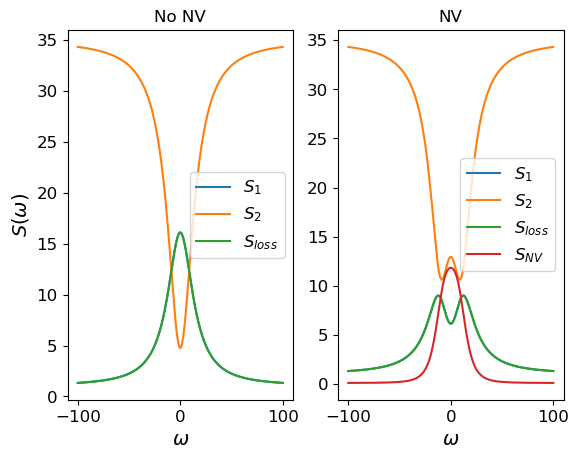

In [66]:
fig = plt.figure(1)
ax = fig.subplots(1, 2)
ax[0].plot(ω, Sa_no_NV, label='$S_1$')
ax[0].plot(ω, Se_no_NV, label='$S_2$')
ax[0].plot(ω, Sb_no_NV, label='$S_{loss}$')
ax[0].legend()
ax[0].set_xlabel("$\\omega$")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].set_title("No NV")

ax[1].plot(ω, Sa, label='$S_1$')
ax[1].plot(ω, Se, label='$S_2$')
ax[1].plot(ω, Sb, label='$S_{loss}$')
ax[1].plot(ω, Sc, label='$S_{NV}$')
ax[1].legend()
ax[1].set_xlabel("$\\omega$")
ax[1].set_title("NV")